In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import time
import cv2
import os

from model import build_pretrained_model
import utils 

import warnings
warnings.filterwarnings("ignore")

## Data Pipeline 

###  Explore Data

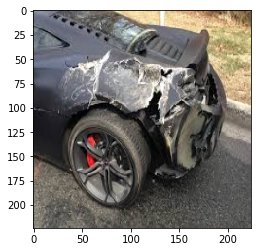

In [2]:
train_path = "data/data3a/training/03-severe/"
path_list = [os.path.join(train_path,filepath) for filepath in os.listdir(train_path)]

idx = 3
img = utils.load_image(path_list[idx])
plt.imshow(img.astype(np.int))
plt.show()

### Create Dataset 

In [3]:
def create_dataset(train_path, test_path=None, valid_size=0.1, batch_size=32):
    X_train, X_val, y_train, y_val = utils.read_data(
        data_path=train_path,
        valid_size=valid_size)

    enc = LabelEncoder()
    enc.fit(y_train)
    print(enc.classes_)
    
    with open("models/label_enc.pkl", "wb") as f:
        pickle.dump(enc, f)

    y_train = enc.transform(y_train)
    y_train = to_categorical(y_train)

    train_gen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    train_gen.fit(X_train)

    y_val = enc.transform(y_val)
    y_val = to_categorical(y_val)

    valid_gen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input)

    valid_gen.fit(X_val)

    print("train: {}".format(len(y_train)))
    print("valid: {}".format(len(y_val)))

    if test_path is not None:
        X_test, y_test = utils.read_data(
            data_path=test_path,
            valid_size=0)

        y_test = enc.transform(y_test)
        y_test = to_categorical(y_test)

        test_gen = image.ImageDataGenerator(
            preprocessing_function=preprocess_input)
        
        test_gen.fit(X_test)

        train_gen = train_gen.flow(X_train, y_train, batch_size)
        valid_gen = valid_gen.flow(X_val, y_val, batch_size)
        test_gen = test_gen.flow(X_test, y_test, batch_size)
        
        print("test: {}".format(len(y_test)))

        return train_gen, valid_gen, test_gen

    valid_gen = valid_gen.flow(X_val, y_val, batch_size)
    test_gen = test_gen.flow(X_test, y_test, batch_size) 

    return train_gen, valid_gen

## Modeling 

### Replace Top layers

In [4]:
def build_pretrained_model(
    base_model,
    hidden_dim=1024, 
    n_classes=6):

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(hidden_dim, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    preds = Dense(n_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=preds)
    
    return model

### Create Model 

In [37]:
hidden_dim = 512
n_classes = 3

base_model = ResNet50(
    input_shape=(224,224,3), 
    weights='imagenet', 
    include_top=False)

model =  build_pretrained_model(
    base_model=base_model,
    hidden_dim=hidden_dim,
    n_classes=n_classes)

# model.summary()

### Adjust trainable layers 

In [38]:
# train only the top layers 
for layer in base_model.layers:
    layer.trainable = False
#     if "5c_" in layer.name and "5b_" in layer.name:
#         layer.trainable = True

### Training Process

In [27]:
def train(model, train_gen, valid_gen, test_gen, 
          train_steps, valid_steps, 
          optim=Adam(lr=1e-4), epochs=30):
    
    model.compile(optimizer=optim, 
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
    
    model.fit_generator(
        generator=train_gen, 
        steps_per_epoch=train_steps,
        validation_data=valid_gen,
        validation_steps=valid_steps,
        epochs=epochs)

    test_loss, test_acc = model.evaluate_generator(test_gen)
    print('accuracy: {}'. format(test_acc))
    print('loss: {}'.format(test_loss))

    model_path = 'models/model_{}acc.h5'.format(int(test_acc*100))
    tf.keras.models.save_model(model, model_path)

    print("Successfully Saved {}".format(model_path))

    return model

### Hyperparameters

In [28]:
learning_rate = 1e-4
batch_size = 32
epochs = 10

In [40]:
train_gen, valid_gen, test_gen = create_dataset(
    train_path="data/data3a/training/",
    test_path="data/data3a/validation/",
    valid_size=0.2,
    batch_size=batch_size)

['01-minor' '02-moderate' '03-severe']
train: 783
valid: 196
test: 171


In [41]:
train_steps = np.ceil(train_gen.n/batch_size)
valid_steps = np.ceil(valid_gen.n/batch_size)

train(model=model,
      train_gen=train_gen,
      valid_gen=valid_gen,
      test_gen=test_gen,
      train_steps=train_steps,
      valid_steps=valid_steps,
      optim=Adam(lr=learning_rate), 
      epochs=epochs)

Epoch 1/10
25/25 [==============================] - 10s 412ms/step - loss: 0.4520 - acc: 0.8159 - val_loss: 0.6102 - val_acc: 0.7398
Epoch 2/10
25/25 [==============================] - 6s 239ms/step - loss: 0.4265 - acc: 0.8409 - val_loss: 0.6065 - val_acc: 0.7551
Epoch 3/10
25/25 [==============================] - 7s 284ms/step - loss: 0.3879 - acc: 0.8568 - val_loss: 0.6297 - val_acc: 0.7245
Epoch 4/10
25/25 [==============================] - 7s 277ms/step - loss: 0.4026 - acc: 0.8598 - val_loss: 0.6390 - val_acc: 0.7143
Epoch 5/10
25/25 [==============================] - 7s 270ms/step - loss: 0.3776 - acc: 0.8735 - val_loss: 0.6999 - val_acc: 0.7092
Epoch 6/10
25/25 [==============================] - 7s 281ms/step - loss: 0.3401 - acc: 0.8934 - val_loss: 0.6377 - val_acc: 0.7347
Epoch 7/10
25/25 [==============================] - 7s 282ms/step - loss: 0.3111 - acc: 0.9083 - val_loss: 0.6907 - val_acc: 0.6837
Epoch 8/10
25/25 [==============================] - 7s 280ms/step - loss: 0

### Testing model performance 

In [11]:
def test(model, X_test, y_test, enc):

    y_test_pred = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred,axis=1)
    
    test_acc = metrics.accuracy_score(enc.transform(y_test), y_test_pred)
    print("Accuracy: {}".format(test_acc))
    
    y_test_pred_labels = enc.inverse_transform(y_test_pred)
    
    cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred_labels, labels=enc.classes_)
    plt.figure()
    utils.plot_confusion_matrix(cm, enc.classes_, normalize=False)
    plt.show()

    return y_test_pred_labels### Testing model performance 

In [42]:
X_test, y_test = utils.read_data("data/data3a/validation/")
X_test = np.array(list(map(preprocess_input, X_test)))

In [43]:
enc = pickle.load(open("models/label_enc.pkl", "rb"))
model = tf.keras.models.load_model("models/model_64acc.h5")

Accuracy: 0.6432748538011696


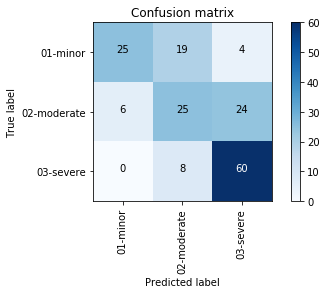

In [44]:
y_test_pred_labels = test(model, X_test, y_test, enc)

### Check the false positive cases 

Pred: 02-moderate, True: 01-minor


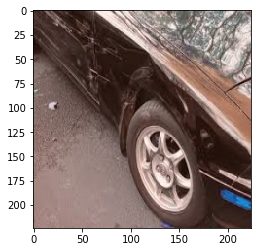

In [45]:
idx = 2

error_mask = (y_test_pred_labels != y_test)
print('Pred: {}, True: {}'. format(y_test_pred_labels[error_mask][idx], y_test[error_mask][idx]))

plt.imshow(utils.standard_scaler(X_test[error_mask][idx]))### Check the false positive cases 